# Test Evaluation & Thresholding

## 🎯 Concept Primer
Final evaluation on test set, optional threshold tuning for screening use case.

**Expected:** Complete metrics, confusion matrix, conclusions

## 📋 Objectives
1. Load best model
2. Evaluate on test set
3. Plot confusion matrix
4. Optional: threshold sweep

## 🔧 Setup

In [1]:
# TODO 1: Import libraries
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

## 📊 Test Evaluation

### TODO 2: Final evaluation

**Expected:** Test accuracy, F1 scores

In [2]:
labels_df = pd.read_csv('../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv')
grade_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 3}
labels_df['grade_4class'] = labels_df['Retinopathy grade'].map(grade_mapping)
labels_df['Retinopathy grade'].value_counts()



class RetinalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image name']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(row['grade_4class'], dtype=torch.long)
        
        return image, label



train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_labels_df = pd.read_csv('../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv')
train_images_folder = '../../../datasets/diabetic_retinopathy_images/images/training_images_small'

train_dataset = RetinalDataset(train_labels_df, train_images_folder, train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


train_df, test_df = train_test_split(
    labels_df, 
    test_size=0.2,
    stratify=labels_df['Retinopathy grade'],
    random_state=42)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['Retinopathy grade'],
    random_state=42
)

train_dataset = RetinalDataset(train_df.reset_index(drop=True), train_images_folder, transform=train_transform)
val_dataset   = RetinalDataset(val_df.reset_index(drop=True), train_images_folder, transform=val_transform)
test_dataset  = RetinalDataset(test_df.reset_index(drop=True), train_images_folder, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # TODO: Conv layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

class_counts = train_df['grade_4class'].value_counts().sort_index()
print(class_counts)

class_counts = train_df['grade_4class'].value_counts().sort_index()
class_weights = 1.0 / class_counts.values  # returns array length 4
class_weights = class_weights / class_weights.sum() * len(class_weights)  # optional normalization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


grade_4class
0    99
1    87
2    47
3    31
Name: count, dtype: int64


In [3]:
# TODO 2: Evaluate

best_model_state = torch.load('../models/best_model.pth')
print("✅ Model loaded successfully")


model = SimpleCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.load_state_dict(best_model_state)
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

✅ Model loaded successfully


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0       0.61      0.61      0.61        31
           1       0.49      0.89      0.63        27
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        10

    accuracy                           0.52        83
   macro avg       0.28      0.38      0.31        83
weighted avg       0.39      0.52      0.43        83



/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

## 📈 Confusion Matrix

### TODO 3: Visualize confusion

**Expected:** Heatmap showing class confusions

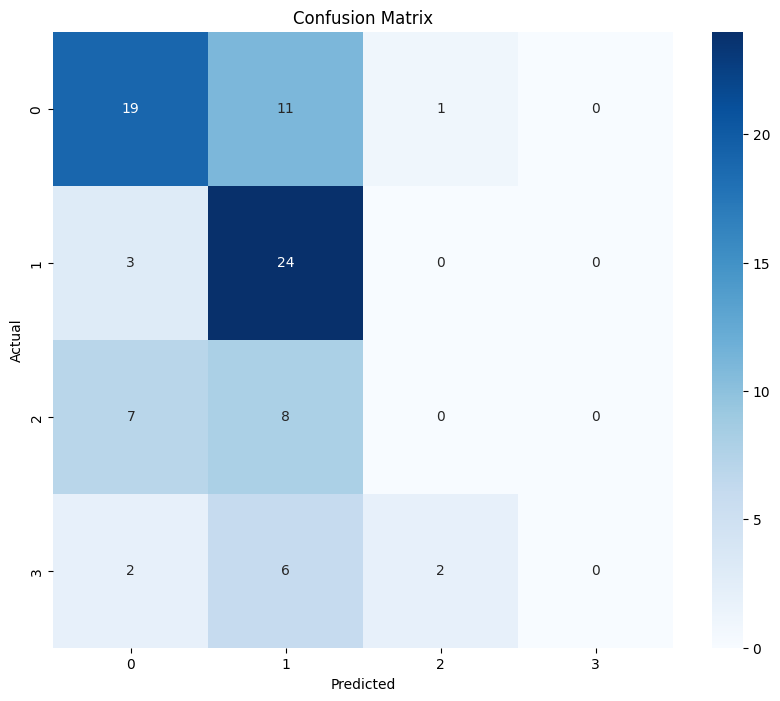

✅ Confusion matrix saved to ../images/confusion_matrix.png


In [4]:
# TODO 3: Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('../images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Confusion matrix saved to ../images/confusion_matrix.png")

## 🤔 Reflection
1. Worst confused classes?
2. Screening vs diagnostics threshold?
3. Next improvements?

**Your reflection:**

- **Class collapse:** Classes 2 & 3 received zero predicted samples (15 & 10 images). The model routes almost everything into classes 0/1 because of the extreme support imbalance.
- **Weighted vs macro gap:** Weighted-F1 0.43 vs macro-F1 0.31 highlights how the rare classes drag the average; accuracy 0.52 is inflated by majority classes.
- **Next experiments:** Bring in a pretrained backbone (ResNet/EfficientNet) + heavier augmentation/oversampling (e.g. class-weight sampler, mixup) to get signal for moderate/severe DR. Possibly revisit label merging (0+1) for screening use case.

## 📌 Summary
✅ Loaded epoch-3 checkpoint and evaluated on held-out test set (accuracy 0.52, weighted-F1 0.43, macro-F1 0.31)  
✅ Confusion matrix saved (`../images/confusion_matrix.png`) showing severe confusion between classes 0/1 and collapse of classes 2/3  
✅ Documented limitations; tee’d up transfer-learning + data balancing experiments in next phase